# Idealized Synthetic Data

*Under development*

In [1]:
import sys; sys.path.append("../../")

import numpy as np
import pandas as pd
import xarray as xr

from melodies_monet import driver

Please install h5py to open files from the Amazon S3 servers.
Please install h5netcdf to open files from the Amazon S3 servers.


In [2]:
an = driver.analysis()
an.control = "control_idealized.yaml"
an.read_control()
an

analysis(
    control='control_idealized.yaml',
    control_dict=...,
    models={},
    obs={},
    paired={},
    start_time=Timestamp('2019-09-09 00:00:00'),
    end_time=Timestamp('2019-09-10 00:00:00'),
    download_maps=True,
    output_dir='./output/idealized',
    debug=True,
)

````{admonition} Note: This is the complete file that was loaded.
:class: dropdown

```{literalinclude} control_idealized.yaml
:caption:
:linenos:
```
````

## Generate data

### Model

In [3]:
rs = np.random.RandomState(42)

control = an.control_dict

nlat = 100
nlon = 200

lon = np.linspace(-161, -60, nlon)
lat = np.linspace(18, 60, nlat)
Lon, Lat = np.meshgrid(lon, lat)

time = pd.date_range(control['analysis']['start_time'], control['analysis']['end_time'], freq="3H")
ntime = time.size

# Generate translating and expanding Gaussian
x_ = np.linspace(-1, 1, lon.size)
y_ = np.linspace(-1, 1, lat.size)
x, y = np.meshgrid(x_, y_)
mu = np.linspace(-0.5, 0.5, ntime)
sigma = np.linspace(0.3, 1, ntime)
g = np.exp(
    -(
        (
            (x[np.newaxis, ...] - mu[:, np.newaxis, np.newaxis])**2
            + y[np.newaxis, ...]**2
        ) / ( 
            2 * sigma[:, np.newaxis, np.newaxis]**2
        ) 
    ) 
)

# Coordinates
lat_da = xr.DataArray(lat, dims="lat", attrs={'longname': 'latitude', 'units': 'degN'}, name="lat")
lon_da = xr.DataArray(lon, dims="lon", attrs={'longname': 'longitude', 'units': 'degE'}, name="lon")
time_da = xr.DataArray(time, dims="time", name="time")

# Generate dataset
field_names = control['model']['test_model']['variables'].keys()
ds_dict = dict()
for field_name in field_names:
    units = control['model']['test_model']['variables'][field_name]['units']
    # data = rs.rand(ntime, nlat, nlon)
    data = g
    da = xr.DataArray(
        data,
        # coords={"lat": lat_da, "lon": lon_da, "time": time_da},
        coords=[time_da, lat_da, lon_da],
        dims=['time', 'lat', 'lon'],
        attrs={'units': units},
    )
    ds_dict[field_name] = da
ds = xr.Dataset(ds_dict).expand_dims("z", axis=1)
ds["z"] = [1]

ds_mod = ds
ds_mod

<xarray.Dataset>
Dimensions:  (time: 9, lat: 100, lon: 200, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 2019-09-09 2019-09-09T03:00:00 ... 2019-09-10
  * lat      (lat) float64 18.0 18.42 18.85 19.27 ... 58.73 59.15 59.58 60.0
  * lon      (lon) float64 -161.0 -160.5 -160.0 -159.5 ... -61.02 -60.51 -60.0
  * z        (z) int32 1
Data variables:
    A        (time, z, lat, lon) float64 0.000964 0.001019 ... 0.5379 0.5353
    B        (time, z, lat, lon) float64 0.000964 0.001019 ... 0.5379 0.5353

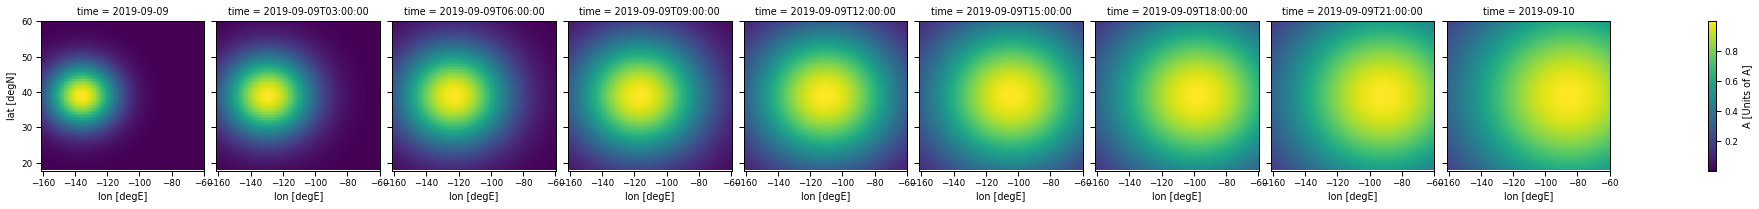

In [4]:
ds.squeeze("z").A.plot(col="time")

In [5]:
ds.to_netcdf(control['model']['test_model']['files'])

### Obs

In [6]:
# Generate positions
# TODO: only within land boundaries
n = 500
lats = rs.uniform(lat[0], lat[-1], n)#[np.newaxis, :]
lons = rs.uniform(lon[0], lon[-1], n)#[np.newaxis, :]
siteid = np.arange(n)[np.newaxis, :].astype(str)

# Generate dataset
field_names = control['model']['test_model']['variables'].keys()
ds_dict = dict()
for field_name0 in field_names:
    field_name = control['model']['test_model']['mapping']['test_obs'][field_name0]
    units = control['model']['test_model']['variables'][field_name0]['units']
    values = (
        ds_mod.A.squeeze().interp(lat=xr.DataArray(lats), lon=xr.DataArray(lons)).values
        + rs.normal(scale=0.3, size=(ntime, n))
    )[:, np.newaxis]
    da = xr.DataArray(
        values,
        coords={
            "x": ("x", np.arange(n)),  # !!!
            "time": ("time", time),
            "latitude": (("y", "x"), lats[np.newaxis, :], lat_da.attrs),
            "longitude": (("y", "x"), lons[np.newaxis, :], lon_da.attrs),
            "siteid": (("y", "x"), siteid),
        },
        dims=("time", "y", "x"),
        attrs={'units': units},
    )
    ds_dict[field_name] = da
ds = xr.Dataset(ds_dict)
ds

<xarray.Dataset>
Dimensions:    (x: 500, time: 9, y: 1)
Coordinates:
  * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time       (time) datetime64[ns] 2019-09-09 ... 2019-09-10
    latitude   (y, x) float64 33.73 57.93 48.74 43.14 ... 21.26 58.92 59.42
    longitude  (y, x) float64 -90.49 -106.9 -129.7 ... -147.2 -65.03 -116.0
    siteid     (y, x) <U11 '0' '1' '2' '3' '4' ... '495' '496' '497' '498' '499'
Dimensions without coordinates: y
Data variables:
    A_obs      (time, y, x) float64 0.06143 -0.3988 0.3937 ... 0.3557 0.5418
    B_obs      (time, y, x) float64 -0.1842 0.1995 0.5878 ... 0.8395 0.6286

In [7]:
ds.to_netcdf(control['obs']['test_obs']['filename'])

## Load data

In [8]:
an.open_models()

test_model
{'files': 'test_model.nc', 'mod_type': 'random', 'variables': {'A': {'units': 'Units of A', 'unit_scale': 1, 'unit_scale_method': '*'}, 'B': {'units': 'Units of B', 'unit_scale': 1, 'unit_scale_method': '*'}}, 'mapping': {'test_obs': {'A': 'A_obs', 'B': 'B_obs'}}, 'projection': 'None'}
test_model.nc


In [9]:
an.models['test_model'].obj

<xarray.Dataset>
Dimensions:  (time: 9, lat: 100, lon: 200, z: 1)
Coordinates:
  * time     (time) datetime64[ns] 2019-09-09 2019-09-09T03:00:00 ... 2019-09-10
  * lat      (lat) float64 18.0 18.42 18.85 19.27 ... 58.73 59.15 59.58 60.0
  * lon      (lon) float64 -161.0 -160.5 -160.0 -159.5 ... -61.02 -60.51 -60.0
  * z        (z) int32 1
Data variables:
    A        (time, z, lat, lon) float64 0.000964 0.001019 ... 0.5379 0.5353
    B        (time, z, lat, lon) float64 0.000964 0.001019 ... 0.5379 0.5353

In [10]:
an.open_obs()

In [11]:
an.obs['test_obs'].obj

<xarray.Dataset>
Dimensions:    (x: 500, time: 9, y: 1)
Coordinates:
  * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time       (time) datetime64[ns] 2019-09-09 ... 2019-09-10
    latitude   (y, x) float64 ...
    longitude  (y, x) float64 ...
    siteid     (y, x) object ...
Dimensions without coordinates: y
Data variables:
    A_obs      (time, y, x) float64 ...
    B_obs      (time, y, x) float64 ...

In [12]:
%%time

an.pair_data()

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
Wall time: 201 ms


In [13]:
an.paired

{'test_obs_test_model': pair(
     type='pt_sfc',
     radius_of_influence=1000000.0,
     obs='test_obs',
     model='test_model',
     model_vars=['A', 'B'],
     obs_vars=['A_obs', 'B_obs'],
     filename='test_obs_test_model.nc',
 )}

In [14]:
an.paired['test_obs_test_model'].obj

<xarray.Dataset>
Dimensions:    (x: 500, time: 9)
Coordinates:
  * x          (x) int32 0 1 2 3 4 5 6 7 8 ... 492 493 494 495 496 497 498 499
  * time       (time) datetime64[ns] 2019-09-09 ... 2019-09-10
Data variables:
    A_obs      (time, x) float64 0.06143 -0.3988 0.1292 ... 0.6373 0.1377 0.5593
    B_obs      (time, x) float64 -0.1842 0.1995 0.4724 ... 0.8742 0.2222 0.3161
    A          (time, x) float64 0.008033 0.001784 0.0003207 ... 0.3443 0.2698
    B          (time, x) float64 0.008033 0.001784 0.0003207 ... 0.3443 0.2698
    latitude   (x) float64 33.73 57.93 18.86 19.32 ... 39.95 35.96 19.07 22.53
    longitude  (x) float64 -90.49 -106.9 -99.05 -143.9 ... -143.6 -141.6 -156.9
    siteid     (x) object '0' '1' '10' '100' '101' ... '95' '96' '97' '98' '99'

In [15]:
an.paired['test_obs_test_model'].obj.dims

Frozen({'x': 500, 'time': 9})

## Plot

Wall time: 4.19 s


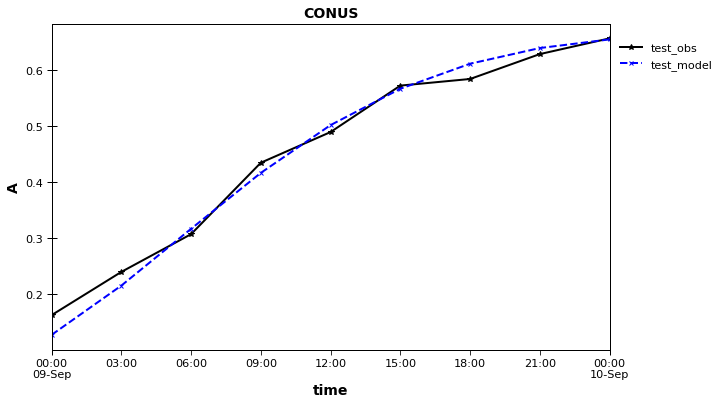

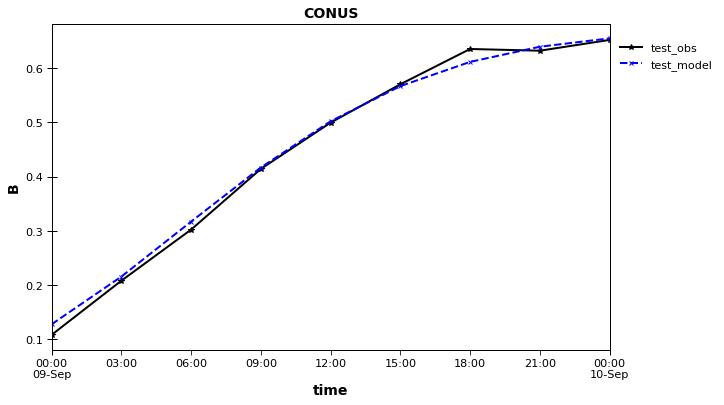

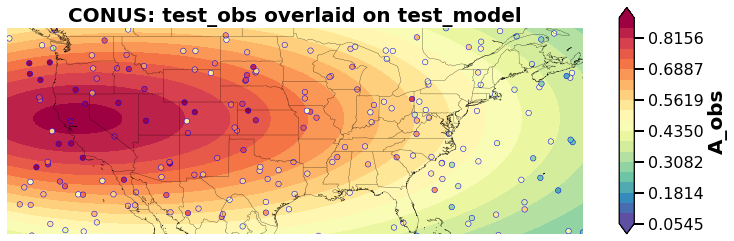

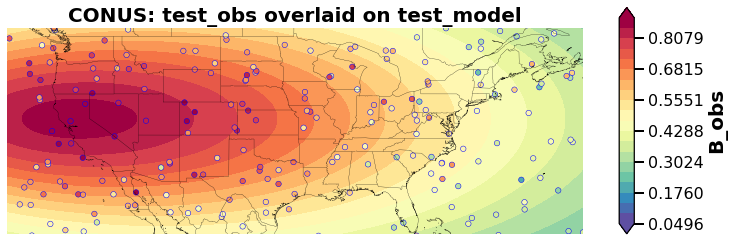

In [16]:
%%time

an.plotting()